<a href="https://colab.research.google.com/github/vaishalivinayaga/Dog-Breed-Identification/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.3 MB/s 


In [3]:
## Imports
import os
import sys
import numpy as np
import pandas as pd
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Import pretrained models
from tensorflow.keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [4]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.9.2
keras version 2.9.0


## **Test GPU + RAM**

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


## **Dog DataSet**

In [7]:
!rm -rf DatasetStore

In [8]:
import requests
import tarfile
dataset_path = "DatasetStore"

# Download and extract dataset
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)
  
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

**Display some training images**

---



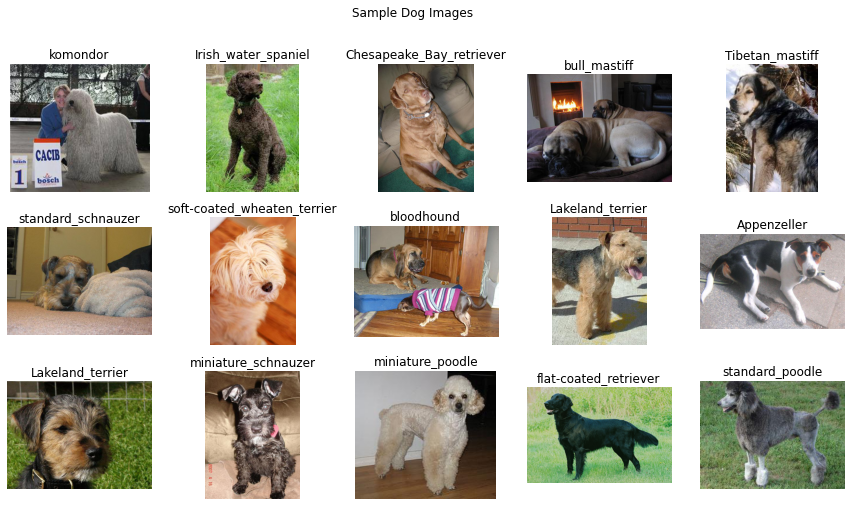

In [9]:
# https://www.kaggle.com/gtimoshaz/dataset-reading-demo

breed_list = os.listdir('DatasetStore/Annotation/') # list of all breeds for further demo

# Train images
fig = plt.figure(figsize=(15,8))
for i in range(15):
    axs = fig.add_subplot(3,5,i+1)
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('DatasetStore/Annotation/' + breed)) # random image 
    img = Image.open('DatasetStore/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('DatasetStore/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() 
    object_1 = root.findall('object')[0]; # finding all dogs. An array
    name = object_1.find('name').text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dog Images")
plt.show()

In [10]:
breed_list = os.listdir('DatasetStore/Annotation/'); # list of all breeds for further demo
breed_list.sort()
for i,breed in enumerate(breed_list):
  breed_list[i] = breed[10:];

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
print(breed_list[:3])

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


**Load data**

In [11]:
breed_list = os.listdir('DatasetStore/Annotation/') # list of all breeds for further demo
breed_list.sort()
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('DatasetStore/Images/' + breed)
  image_files.sort()
  images.extend([os.path.join('DatasetStore/Images/',breed,f) for f in image_files])
  annotations.extend([os.path.join('DatasetStore/Annotation/',breed,f.replace(".jpg","")) for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2] # add dog breed name

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)

print('Xs shape',Xs.shape)
print(Xs[:5])
print('Ys shape',Ys.shape)
print(Ys[:5])

# Split into train_validate + test data
train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

print("train_validate_x shape:",train_validate_x.shape)
print('train_validate_x[:5]:',train_validate_x[:5])
print("train_validate_y shape:",train_validate_y.shape)
print('train_validate_y[:5]:',train_validate_y[:5])

print("test_x shape:",test_x.shape)
print('test_x[:5]:',test_x[:5])
print("test_y shape:",test_y.shape)
print('test_y[:5]:',test_y[:5])

Xs shape (20580,)
['DatasetStore/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10621.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_1073.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10976.jpg']
Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua'
 'n02085620-Chihuahua' 'n02085620-Chihuahua']
train_validate_x shape: (18522,)
train_validate_x[:5]: ['DatasetStore/Images/n02096585-Boston_bull/n02096585_2379.jpg'
 'DatasetStore/Images/n02097130-giant_schnauzer/n02097130_5560.jpg'
 'DatasetStore/Images/n02096294-Australian_terrier/n02096294_8476.jpg'
 'DatasetStore/Images/n02106382-Bouvier_des_Flandres/n02106382_241.jpg'
 'DatasetStore/Images/n02109525-Saint_Bernard/n02109525_3448.jpg']
train_validate_y shape: (18522,)
train_validate_y[:5]: ['n02096585-Boston_bull' 'n02097130-giant_schnauzer'
 'n02096294-Australian_terrier'

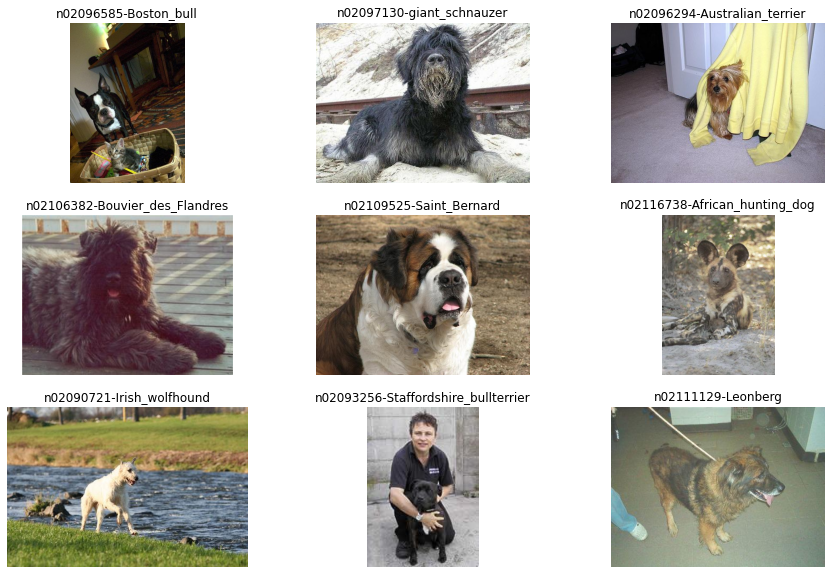

In [12]:
# View a few train images
fig = plt.figure(figsize=(15,10))

for idx in range(9):
  sample_input = cv2.imread(train_validate_x[idx])
  sample_input = cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB)
  breed = train_validate_y[idx];
  axs = fig.add_subplot(3,3,idx+1)
  axs.set_title(breed)
  plt.imshow(sample_input)
  plt.axis('off')

plt.show();



## **Build Data Generator**

In [13]:
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list);

epochs = 30
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3

# Split data into train / validation
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent) 

#  Converts to binary class matrix (One-hot-encoded)
train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = np.int(train_data_count / train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = np.int(validation_data_count / validation_batch_size)

# Prepare the data
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

# Normalize pixels
def normalize(image, label):
    image = image/255
    return image, label 

def build_data_generators(train_data_process_list=[load_image,normalize],validate_data_process_list=[load_image,normalize],test_data_process_list=[load_image,normalize]):

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))


    # Train data
    # Shuffle
    train_data = train_data.shuffle(train_data_count)
    # Apply all data processing logic
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
    
    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    # Shuffle
    validation_data = validation_data.shuffle(validation_data_count)
    # Apply all data processing logic
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)
    
    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    # Apply all data processing logic
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)
    
    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

<ipython-input-13-77d687e34892>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  steps_per_epoch = np.int(train_data_count / train_batch_size)
<ipython-input-13-77d687e34892>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

train_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
validation_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
test_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


## **Utility Function**

In [14]:
class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)
        
def get_model_metrics():
    with open("./SavedModels/model_metrics.json") as json_file:
        model_metrics = json.load(json_file)
    
    return model_metrics

def save_model_metrics(model_name="model_1",metrics={}):
    if os.path.exists("./SavedModels/model_metrics.json"):
        with open("./SavedModels/model_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}
    
    model_metrics[model_name] = metrics
    
    # Save the json
    with open("./SavedModels/model_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))
        
def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):
    
    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()
    
    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()
    
    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)
    
    if save:
        # Save model
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("./SavedModels",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

Compare all models

In [17]:
# Compare model metrics
view_metrics = pd.read_json("./SavedModels/model_metrics.json")
view_metrics = view_metrics.T
# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
#view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)
print('Number of models:',view_metrics.shape[0])

ValueError: ignored

## **VGG16**
Use VGG16 as the base and fine tune the last conv2d block for our problem

### Build model

In [16]:
# vgg16 with fine tuning the last conv2d base
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []
    
    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
            'trainable':layer.trainable
        })
    
    df = pd.DataFrame(layers_list)
    
    return df

layers_df = view_layers(vgg16)
print(layers_df[10:])

58889256/58889256 [==============================] - 0s 0us/step
           layer  trainable
10  MaxPooling2D       True
11        Conv2D       True
12        Conv2D       True
13        Conv2D       True
14  MaxPooling2D       True
15        Conv2D       True
16        Conv2D       True
17        Conv2D       True
18  MaxPooling2D       True


### Training params

In [18]:
############################
# Training Params
############################
learning_rate = 0.001
batch_size = 32
epochs = 50
############################


# Set all layers as trainable false execpt last conv block
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Input
model_input = vgg16.layers[0].input

# Final pool layer
hidden = vgg16.layers[-1]
print("Pool Layer",hidden)

# Flatten
hidden = layers.Flatten()(hidden.output)

#  Hidden Layer, Classification Block
hidden = layers.Dense(units=1024, activation='relu')(hidden)
hidden = layers.Dense(units=1024, activation='relu')(hidden)

# Output Layer
output = layers.Dense(units=num_classes, activation='softmax')(hidden)

# Build model
model = Model(model_input, output, name='VGG16')

# Optimizer
optimizer = optimizers.SGD(lr=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

#print(model.summary())
layers_df = view_layers(model)
print(layers_df.head(25))



Pool Layer <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f981f823e80>
           layer  trainable
0     InputLayer      False
1         Conv2D      False
2         Conv2D      False
3   MaxPooling2D      False
4         Conv2D      False
5         Conv2D      False
6   MaxPooling2D      False
7         Conv2D      False
8         Conv2D      False
9         Conv2D      False
10  MaxPooling2D      False
11        Conv2D      False
12        Conv2D      False
13        Conv2D      False
14  MaxPooling2D      False
15        Conv2D       True
16        Conv2D       True
17        Conv2D       True
18  MaxPooling2D       True
19       Flatten       True
20         Dense       True
21         Dense       True
22         Dense       True


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Train model

In [ ]:
# Train model

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_VGG16'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=epochs, 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/50
 51/463 [==>...........................] - ETA: 40:59 - loss: 4.8749 - accuracy: 0.0098

### Evaluate and Save

In [ ]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## **ResNet50V2 with Adam optimizer**

In [ ]:
resnet50_v2 = ResNet50V2(
    include_top=False,
    input_shape=(128, 128, 3)
)

### Build model

In [ ]:
# Build model for Resnet
def build_resnet_model(model_name = 'ResNet50V2',print_summary=True):
  # Set all layers as hidden
  for layer in resnet50_v2.layers:
      layer.trainable = False

  # Input
  model_input = resnet50_v2.layers[0].input

  # Extract final pool layer
  hidden = resnet50_v2.layers[-1]

  # Flatten 
  hidden = layers.Flatten()(hidden.output)

  # Output Layer
  output = layers.Dense(units=120, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  # Print the model architecture
  if print_summary:
    print(model.summary())

  return model

### Training params

In [ ]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model()

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])




### Train model

In [ ]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback], 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


### Evaluate and Save

In [ ]:
# Evaluate and Save model
learning_rate = 0.001;
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Add data augmentation to ResNet50V2

In [ ]:
# Create data augmentation processors

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness
def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast
def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

# Apply data processing + data augmentation steps
data_process_list=[load_image, normalize, adjust_brightness, adjust_contrast]

# Build data generators for train, validate, test
train_data, validation_data, test_data = build_data_generators(train_data_process_list=data_process_list)
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

### Build model

In [ ]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2DataAug'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(model_name='ResNet50V2_DataAug')

# Loads the weights
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2'
model.load_weights(checkpoint_path)

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Train model

In [ ]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback], 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

### Evaluate and Save

In [ ]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Display predictions

In [ ]:
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/ResNet50V2_DataAug.hdf5')
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2DataAug'
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_data)

# Load Test images
test_x_display = []
for path in test_x:
    # read image
    image = cv2.imread(path)
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Train x
    test_x_display.append(image)

# Convert to numpy array
test_x_display = np.asarray(test_x_display)

# add true and predicted breed for each dog image
# mark it green if prediction is true, otherwise red
# count the total number of true predictions for the first 100 images
true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))
for i,file in enumerate(test_x_display[:50]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] # [10:] truncates leading unnecessary letters
    true_breed = test_y[i][10:]
    # color code true/false predictions
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green')
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
    plt.imshow(test_x_display[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)

## **Compare all models**

In [ ]:
view_metrics.sort_values(by=['accuracy'],ascending=False).head(10)